# 01.01 - PROYECTO KAGGLE

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [21]:
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

import os
if os.path.exists("/content/Kaggle-2.json"):
    !mv -f /content/Kaggle-2.json ~/.kaggle/kaggle.json
elif os.path.exists("/content/kaggle.json"):
    !mv -f /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

!kaggle config view


Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 65 Oct  5 20:06 kaggle.json
{"username":"yiyilopez","key":"0f77a85befe865278ce7b5a178c60b2d"}Configuration values from /root/.kaggle
- username: yiyilopez
- path: None
- proxy: None
- competition: None


In [22]:
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.28GB/s]


## unzip and inspect data

In [23]:
!unzip udea*.zip > /dev/null

In [24]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


## load `train.csv` data with pandas



In [25]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 21)


In [26]:
z.head()

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


## we will do a model using only two columns

- we have to predict column `RENDIMIENTO_GLOBAL` using the rest

- we will use columns
  - `FAMI_EDUCACIONMADRE` which we will need to convert to a **onehot encoding**
  - `ESTU_VALORMATRICULAUNIVERSIDAD` which we will need to convert to a **continuous encoding**

In [27]:
z = z[['F_EDUCACIONMADRE', 'E_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]
z.head()

,F_EDUCACIONMADRE,E_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,Postgrado,Entre 5.5 millones y menos de 7 millones,medio-alto
1,Técnica o tecnológica incompleta,Entre 2.5 millones y menos de 4 millones,bajo
2,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones,bajo
3,Secundaria (Bachillerato) completa,Entre 4 millones y menos de 5.5 millones,alto
4,Primaria completa,Entre 2.5 millones y menos de 4 millones,medio-bajo


<Axes: xlabel='F_EDUCACIONMADRE'>

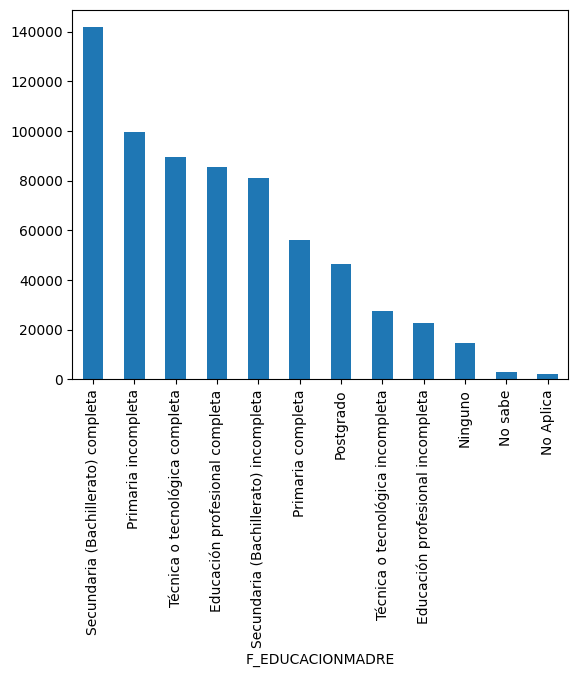

In [28]:
z.F_EDUCACIONMADRE.value_counts().plot(kind='bar')

<Axes: xlabel='E_VALORMATRICULAUNIVERSIDAD'>

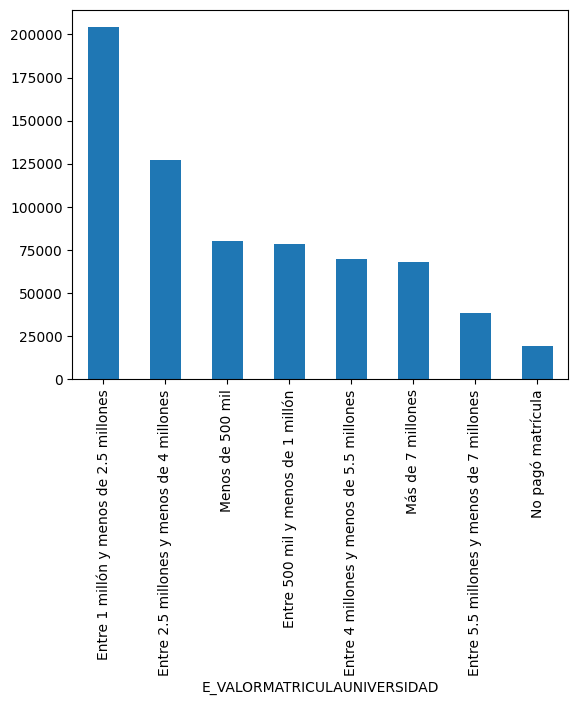

In [29]:
z.E_VALORMATRICULAUNIVERSIDAD.value_counts().plot(kind='bar')

## Inspect visually if these two columns have distinctive behaviour with respect to what we want to predict

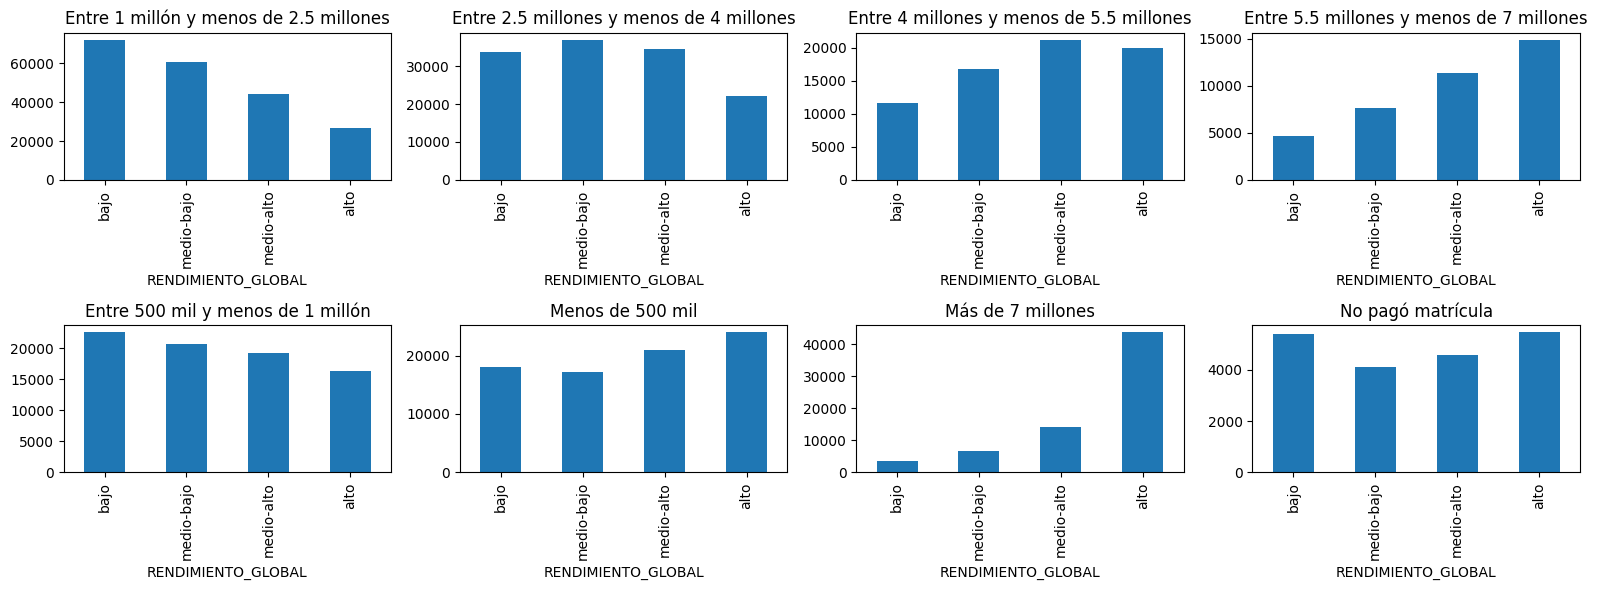

In [30]:
from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.E_VALORMATRICULAUNIVERSIDAD.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.E_VALORMATRICULAUNIVERSIDAD==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

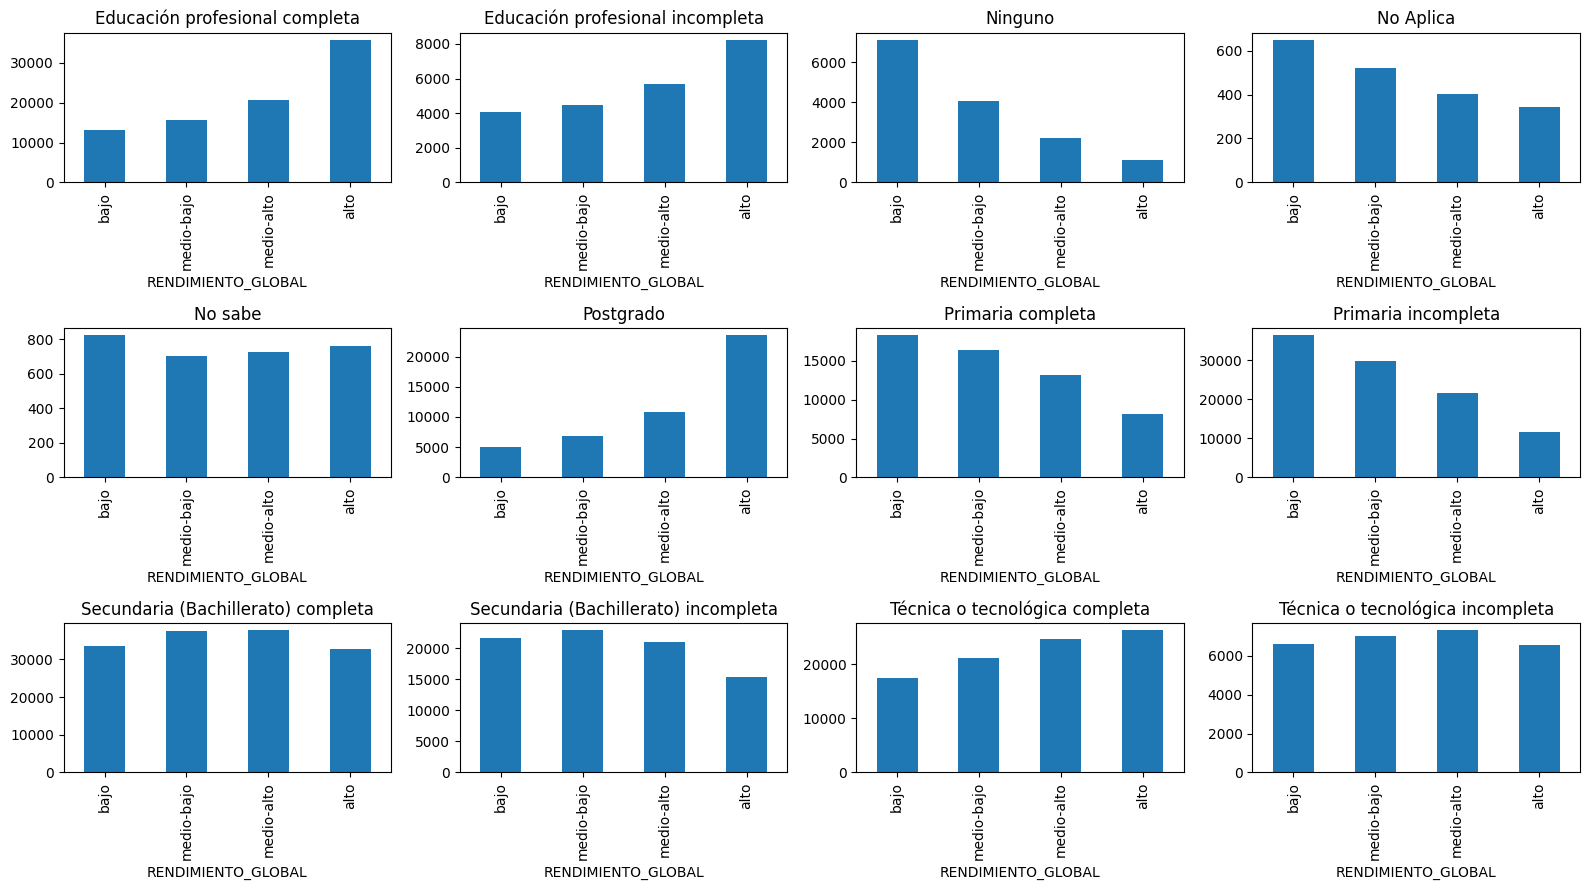

In [31]:
c = sorted(z.F_EDUCACIONMADRE.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.F_EDUCACIONMADRE==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

## Basic cleanup

considering that we have in total 692K data items, we have realatively few missing values on each column

In [32]:
sum(z.F_EDUCACIONMADRE.isna()), sum(z.E_VALORMATRICULAUNIVERSIDAD.isna())

(23664, 6287)

we will substitute `nan` values with a preset symbol to mark them

In [33]:
z.F_EDUCACIONMADRE.values[z.F_EDUCACIONMADRE.isna()] = 'no info'
z.E_VALORMATRICULAUNIVERSIDAD.values[z.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
sum(z.F_EDUCACIONMADRE.isna()), sum(z.E_VALORMATRICULAUNIVERSIDAD.isna())

(0, 0)

### Cleaning `ESTU_VALORMATRICULAUNIVERSIDAD`

we convert `ESTU_VALORMATRICULAUNIVERSIDAD` to a **continuous** value since the ordering makes sense and we would like models to have a chance to capture it.

observe we assign `no info` to -1, which is somewhat artificial in this case

In [34]:
cmap = {'Entre 1 millón y menos de 2.5 millones': 1.75,
 'Entre 2.5 millones y menos de 4 millones': 3.25,
 'Menos de 500 mil': .250,
 'Entre 500 mil y menos de 1 millón': .75,
 'Entre 4 millones y menos de 5.5 millones': 4.75,
 'Más de 7 millones': 7.75,
 'Entre 5.5 millones y menos de 7 millones': 6.25,
 'No pagó matrícula': 0,
 'no info': -1}

z.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.E_VALORMATRICULAUNIVERSIDAD]]
z.E_VALORMATRICULAUNIVERSIDAD.value_counts()

,count
E_VALORMATRICULAUNIVERSIDAD,
1.75,204048
3.25,127430
0.25,80263
0.75,78704
4.75,69736
7.75,68014
6.25,38490
0.00,19528
-1.00,6287


### Cleaning `FAMI_EDUCACIONMADRE`

observe that for `FAMI_EDUCACIONMADRE` there could be many choices on how to deal with missing data

- leave it as it is
- unite `no info`, `No sabe` , `No Aplica` into a single symbol
- etc.

since there are not so many `No sabe`, `No aplica` probably they wont have much effect on the final result so we will unite them into a single value so that there are not so many columns in the one hot encoding


In [35]:
z = z.copy()
z.F_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.F_EDUCACIONMADRE.values]

In [36]:
z.F_EDUCACIONMADRE.value_counts()

,count
F_EDUCACIONMADRE,
Secundaria (Bachillerato) completa,141744
Primaria incompleta,99420
Técnica o tecnológica completa,89542
Educación profesional completa,85326
Secundaria (Bachillerato) incompleta,81012
Primaria completa,56125
Postgrado,46246
no info,28599
Técnica o tecnológica incompleta,27533


first we create the onehot mapping

In [37]:
x = z.F_EDUCACIONMADRE.values
F_EDUCACIONMADRE_vals = sorted(np.unique(x))
F_EDUCACIONMADRE_onehot_vals = {val: np.eye(len(F_EDUCACIONMADRE_vals))[i] for i,val in enumerate(F_EDUCACIONMADRE_vals)}
F_EDUCACIONMADRE_onehot_vals

{'Educación profesional completa': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Educación profesional incompleta': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Ninguno': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Postgrado': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'Primaria completa': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'Primaria incompleta': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) completa': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) incompleta': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'Técnica o tecnológica completa': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'Técnica o tecnológica incompleta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'no info': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [38]:
F_EDUCACIONMADRE_onehot_enc = np.r_[[F_EDUCACIONMADRE_onehot_vals[i] for i in z.F_EDUCACIONMADRE]]
F_EDUCACIONMADRE_onehot_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [39]:
F_EDUCACIONMADRE_df = pd.DataFrame(F_EDUCACIONMADRE_onehot_enc, columns=[f"F_EDUCACIONMADRE__{v}" for v in F_EDUCACIONMADRE_onehot_vals])
F_EDUCACIONMADRE_df

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692498,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


and we assemble everything into a single dataframe, removing the original `FAMI_EDUCACIONMADRE` column.

we now have 13 columns ... why?


In [40]:
z = pd.concat([F_EDUCACIONMADRE_df, z], axis=1).drop('F_EDUCACIONMADRE', axis=1)
z.shape

(692500, 13)

In [41]:
z.head()

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,E_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.25,medio-alto
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.25,bajo
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.25,bajo
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.75,alto
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.25,medio-bajo


## convert target (prediction) column into discrete values

now everything in our dataset is **numeric**!!!

In [42]:
y_col = 'RENDIMIENTO_GLOBAL'

rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
z[y_col] = [rmap[i] for i in z[y_col]]
z.head()

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,E_VALORMATRICULAUNIVERSIDAD,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.25,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.25,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.25,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.75,3
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.25,1


## build `X` and `y` for training a model

observe we sort columns to make sure we always get the same ordering

In [43]:
z = z[sorted(z.columns)]

X = z[[c for c in z.columns if c!=y_col]].values
y = z[y_col].values
X.shape, y.shape

((692500, 12), (692500,))

## split into train and test

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 12), (138500, 12), (554000,), (138500,))

## Make a linear model for classification

train model

In [46]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtr, ytr)

LogisticRegression()

get predictions

In [47]:
preds_tr = lr.predict(Xtr)
preds_ts = lr.predict(Xts)

In [48]:
print (preds_tr[:10])
print (preds_ts[:10])

[3 3 3 3 0 2 0 3 3 1]
[0 0 0 2 2 0 0 3 1 0]


get accuracy and confusion matrices

In [49]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(np.float64(0.34771841155234656), np.float64(0.3475162454873646))

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

observe how each row in the confusion matrix adds up to 1. What does this mean?

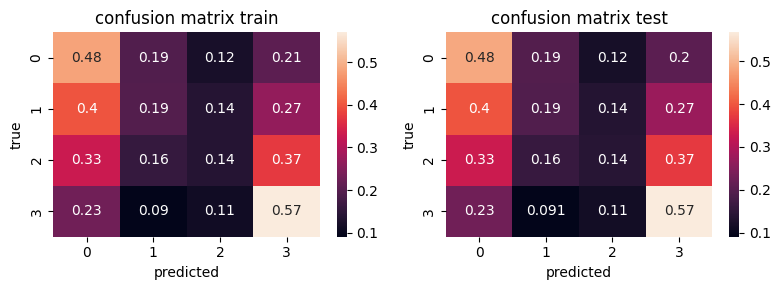

In [52]:
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## is the column `FAMI_EDUCACIONMADRE` really contributing?

remove it and compare scores

In [53]:
zh = z[['E_VALORMATRICULAUNIVERSIDAD', y_col]]

X = zh[[c for c in zh.columns if c!=y_col]].values
y = zh[y_col].values
X.shape, y.shape

((692500, 1), (692500,))

In [54]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
lr_small = LogisticRegression()
lr_small.fit(Xtr, ytr)

LogisticRegression()

In [55]:
preds_tr = lr_small.predict(Xtr)
preds_ts = lr_small.predict(Xts)
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(np.float64(0.3178285198555957), np.float64(0.3168664259927798))

where is it helping?

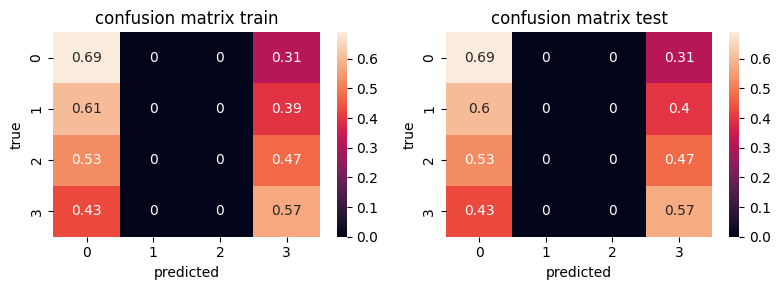

In [56]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## We keep the first model, now we apply the same procedure to `test.csv`

observe:
- there is no `RENDIMIENTO_GLOBAL` column
- we must keep the IDs so that we can create properly the submission file

In [57]:
zt = pd.read_csv("test.csv")
zt

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Si,Si,N,Si,Si,Si,Primaria incompleta,0.168,0.410,0.235,0.300
296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Si,No,N,No,Si,Si,Educación profesional completa,0.471,0.184,0.264,0.193
296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Educación profesional completa,0.292,0.249,0.276,0.256
296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Si,No,N,No,Si,Si,Educación profesional completa,0.305,0.219,0.310,0.260


In [59]:
zt_ids = zt['ID'].values
zt = zt[['F_EDUCACIONMADRE', 'E_VALORMATRICULAUNIVERSIDAD']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,F_EDUCACIONMADRE,E_VALORMATRICULAUNIVERSIDAD
0,Primaria completa,Menos de 500 mil
1,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones
2,Secundaria (Bachillerato) completa,Entre 1 millón y menos de 2.5 millones
3,Primaria incompleta,Entre 1 millón y menos de 2.5 millones
4,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones


In [60]:
zt.F_EDUCACIONMADRE.values[zt.F_EDUCACIONMADRE.isna()] = 'no info'
zt.E_VALORMATRICULAUNIVERSIDAD.values[zt.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'


In [62]:
zt = zt.copy()
zt.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in zt.E_VALORMATRICULAUNIVERSIDAD]]


In [63]:
zt.F_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.F_EDUCACIONMADRE.values]
F_EDUCACIONMADRE_onehot_enc = np.r_[[F_EDUCACIONMADRE_onehot_vals[i] for i in zt.F_EDUCACIONMADRE]]
F_EDUCACIONMADRE_df = pd.DataFrame(F_EDUCACIONMADRE_onehot_enc, columns=[f"F_EDUCACIONMADRE__{v}" for v in F_EDUCACIONMADRE_onehot_vals])
zt = pd.concat([F_EDUCACIONMADRE_df, zt], axis=1).drop('F_EDUCACIONMADRE', axis=1)
zt.shape

(296786, 12)

In [64]:
zt

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,E_VALORMATRICULAUNIVERSIDAD
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.25
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.75
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.75
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.25
296782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.75
296783,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.25
296784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.25


create `X` array and predict

In [65]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data.shape

(296786, 12)

In [66]:
preds_test_data = lr.predict(X_test_data)

## prepare submission

first, map back the predictions to textual values

In [67]:
# inverse mapping
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]


In [68]:
# create dataframe

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,alto
2,499179,medio-bajo
3,782980,bajo
4,785185,medio-alto
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,alto
296784,963852,alto


In [69]:
# save to file ready to submit
submission.to_csv("my_submission.csv", index=False)

In [70]:
!head my_submission.csv

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,alto
499179,medio-bajo
782980,bajo
785185,medio-alto
58495,medio-bajo
705444,medio-alto
557548,alto
519909,medio-bajo


In [71]:
submission.shape

(296786, 2)

## Send your submission to Kaggle

You must **join the competition** first

In [73]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f my_submission.csv -m "Modelo lineal ajustado con normalización"

100% 3.85M/3.85M [00:00<00:00, 13.4MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia

## Things you can try

- other models (svm, random forest, gaussian, etc.)
- different parameters in the models (like `gamma` for svm, or `max_depth` for random forests). see the doc of each model in `sklearn`.
- use different preprocessing and cleaning methods for different columns
- create new columns manually, for instance,
    - group `ESTU_PRGM_ACADEMICO` into areas of knowlege (engineering, social sciences, etc.)
    - do some operation between columns (multiply, concatenate, etc.)
- integrate external data as new columns, for instance, economic data from each department in Colombia, for each different year, etc.
